# People & Vehicle Detection

### Objective
Our objective for this project is to classify images based on the onjects present in the image. But we have to take it one step further by identifying the objects present in the image and not just assigning them a label

We have created two models, one to identify people and another for vehicles. Each model classifyies the given image into 4 classes.

The people model identifies if the image has one of the following people:
1. Narendra Modi
2. Rahul Ghandhi
3. Arvind Kejriwal
4. Donald Trump

The vehicle model identifies if one of the following cars appear in the image:
1. i20
3. Swift
3. Endeavour
4. BMW M3

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os, os.path
import re
import sys
from random import randint
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [1]:
DIR = '/Users/ratnasambhavpriyadarshi/Development/People-and-Vehicle-Detection'
MODEL_PATH = DIR + '/models'
CAR_IMAGE = DIR + '/test-images/car.png'
INPUT_IMAGE = DIR + '/test-images/nm.jpg'
FACE_IMAGE = DIR + '/extracted/face.jpg'

First, we will write a program to create a graph from a saved GraphDef protocol buffer, and runs inference on an input JPEG image. It outputs human readable strings of the top k predictions along with their probabilities. This program performs image classification with Inception trained on ImageNet 2012 Challenge data set.

In [3]:
class NodeLookup(object):
    """Converts integer node ID's to human readable labels."""
    
    def __init__(self, label_lookup_path=None, uid_lookup_path=None):
        if not label_lookup_path:
            label_lookup_path = os.path.join(DIR, 'imagenet/imagenet_2012_challenge_label_map_proto.pbtxt')
        if not uid_lookup_path:
            uid_lookup_path = os.path.join(DIR, 'imagenet/imagenet_synset_to_human_label_map.txt')
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
    
    def load(self, label_lookup_path, uid_lookup_path):
        """Loads a human readable English name for each softmax node.

        Args:
          label_lookup_path: string UID to integer node ID.
          uid_lookup_path: string UID to human-readable string.

        Returns:
          dict from integer node ID to human-readable string.
        """
        
        if not tf.gfile.Exists(uid_lookup_path):
            tf.logging.fatal('File does not exist %s', uid_lookup_path)
        if not tf.gfile.Exists(label_lookup_path):
            tf.logging.fatal('File does not exist %s', label_lookup_path)
        
        # Loads mapping from string UID to human-readable string
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        p = re.compile(r'[n\d]*[ \S,]*')
        for line in proto_as_ascii_lines:
            parsed_items = p.findall(line)
            uid = parsed_items[0]
            human_string = parsed_items[2]
            uid_to_human[uid] = human_string

        # Loads mapping from string UID to integer node ID.
        node_id_to_uid = {}
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                target_class_string = line.split(': ')[1]
                node_id_to_uid[target_class] = target_class_string[1:-2]

        # Loads the final mapping of integer node ID to human-readable string
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            if val not in uid_to_human:
                tf.logging.fatal('Failed to locate: %s', val)
            name = uid_to_human[val]
        node_id_to_name[key] = name

        return node_id_to_name

    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

In [4]:
def create_graph():
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile(os.path.join(
        DIR, 'imagenet/classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

In [5]:
def maybe_download_and_extract():
  """Download and extract model tar file."""
  dest_directory = DIR + '/imagenet'
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [6]:
def run_inference_on_image(image, k):
    """Runs inference on an image.

    Args:
        image: Image file name.
        k: No of top labels to be predicted

    Returns:
        top_k: Array of predicted labels.
      """
    if not tf.gfile.Exists(image):
        tf.logging.fatal('File does not exist %s', image)
    image_data = tf.gfile.FastGFile(image, 'rb').read()

    # Creates graph from saved GraphDef.
    create_graph()

    with tf.Session() as sess:
        # Some useful tensors:
        # 'softmax:0': A tensor containing the normalized prediction across
        #   1000 labels.
        # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
        #   float description of the image.
        # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
        #   encoding of the image.
        # Runs the softmax tensor by feeding the image_data as input to the graph.
        softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
        predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})
        predictions = np.squeeze(predictions)

        # Creates node ID --> English string lookup.
        node_lookup = NodeLookup()

        top_k = predictions.argsort()[-k:][::-1]

        for node_id in top_k:
            human_string = node_lookup.id_to_string(node_id)
            score = predictions[node_id]
            print('%s (score = %.5f)' % (human_string, score))

In [13]:
run_inference_on_image(INPUT_IMAGE, 10)

 (score = 0.20143)
 (score = 0.07610)
 (score = 0.02822)
 (score = 0.02655)
 (score = 0.01999)
 (score = 0.01672)
 (score = 0.01385)
 (score = 0.01348)
 (score = 0.01234)
 (score = 0.01049)


### Model 1: Identifying Politicians

Now we will extract all the faces in the image and run our second model, which idenfities if an image has one of the following prople in it:
1. Narendra Modi
2. Arvind Kejriwal
3. Donald Trump
4. Rahul Gandhi

First, lets extract the faces using OpenCV 2.

In [7]:
CASCADE = DIR + '/Face_cascade.xml'
FACE_CASCADE = cv2.CascadeClassifier(CASCADE)

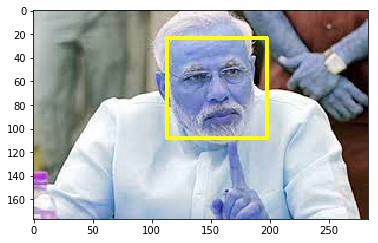

In [8]:
image=cv2.imread(INPUT_IMAGE)
image_grey=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

faces = FACE_CASCADE.detectMultiScale(image_grey,scaleFactor=1.16,minNeighbors=5,minSize=(25,25),flags=0)

for x,y,w,h in faces:
    sub_img=image[y-10:y+h+10,x-10:x+w+10]
    os.chdir(DIR + '/extracted')
    cv2.imwrite("face.jpg",sub_img)
    os.chdir("../")
    cv2.rectangle(image,(x,y),(x+w,y+h),(255, 255,0),2)

plt.imshow(image)
plt.show()
if (cv2.waitKey(0) & 0xFF == ord('q')) or (cv2.waitKey(0) & 0xFF == ord('Q')):
    cv2.destroyAllWindows()

Extracted image:


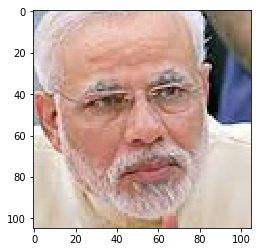

In [9]:
print("Extracted image:")
face = cv2.imread(FACE_IMAGE)
face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB) 
plt.imshow(face)
plt.show()

Now that we have found a face and extracted it, we will feed the face to our model to classify it in one of the four cataegories.

In [10]:
image_data = tf.gfile.FastGFile(FACE_IMAGE, 'rb').read()

label_lines = [line.rstrip() for line
                   in tf.gfile.GFile(MODEL_PATH + "/politicians_labels.txt")]

with tf.gfile.FastGFile(MODEL_PATH + "/politicians.pb", 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

with tf.Session() as sess2:

    softmax_tensor = sess2.graph.get_tensor_by_name('final_result:0')

    predictions = sess2.run(softmax_tensor, \
             {'DecodeJpeg/contents:0': image_data})

    top_k = predictions[0].argsort()[-len(predictions[0]):][::-1]

    for node_id in top_k:
        human_string = label_lines[node_id]
        score = predictions[0][node_id]
        print('%s (score = %.5f)' % (human_string, score))

narendra modi (score = 0.99554)
arvind kejriwal (score = 0.00371)
rahul gandhi (score = 0.00068)
donald trump (score = 0.00007)


### Model 2: Identifying Cars

Now we will try to identify the car present in our image. Our current model identifyies of the car present in an image is one of the following:
1. Hyundai i20
2. Maruti Suziki Swift
3. Ford Endeavour
4. BMW M3

We will change the input image from an image of an human to that of a car.

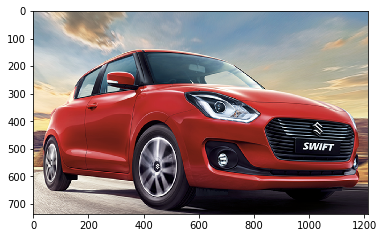

In [11]:
car = cv2.imread(CAR_IMAGE)
car = cv2.cvtColor(car,cv2.COLOR_BGR2RGB)
plt.imshow(car)
plt.show()

In [12]:
image_data = tf.gfile.FastGFile(INPUT_IMAGE, 'rb').read()

label_lines = [line.rstrip() for line
                   in tf.gfile.GFile(MODEL_PATH + "/cars_labels.txt")]

with tf.gfile.FastGFile(MODEL_PATH + "/cars.pb", 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

with tf.Session() as sess3:

    softmax_tensor = sess3.graph.get_tensor_by_name('final_result:0')

    predictions = sess3.run(softmax_tensor, \
             {'DecodeJpeg/contents:0': image_data})

    top_k = predictions[0].argsort()[-len(predictions[0]):][::-1]

    for node_id in top_k:
        human_string = label_lines[node_id]
        score = predictions[0][node_id]
        print('%s (score = %.5f)' % (human_string, score))

swift (score = 0.97923)
endeavour (score = 0.01698)
i20 (score = 0.00329)
m3 (score = 0.00050)


## Thank You!